<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/main/alzheimer's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive

# 1. Montar Google Drive
drive.mount('/content/gdrive')

# 2. Indicar la ubicación del token API en tu Drive
# Reemplaza 'Kaggle_API' con el nombre de tu carpeta si es diferente
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle_API"

Mounted at /content/gdrive


In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 99% 1.22G/1.23G [00:13<00:00, 355MB/s]
100% 1.23G/1.23G [00:13<00:00, 100MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_116.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_117.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_118.jpg  
 

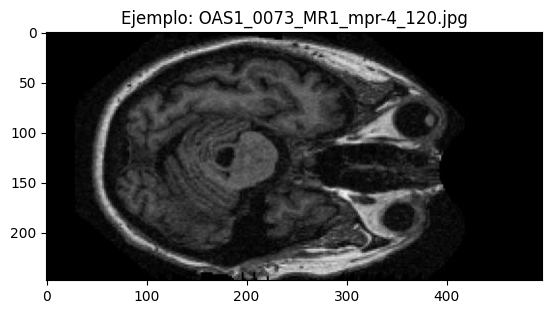

In [ ]:
# Descomprimir el archivo (reemplaza 'ccdata.zip' con el nombre del archivo descargado)
# ¡Asegúrate de que este sea el nombre que se descargó!
!unzip imagesoasis.zip

import os
import matplotlib.pyplot as plt
from PIL import Image

# 1. Lista las carpetas creadas (los nombres de las carpetas son las "clases" o etiquetas)
base_dir = 'Data' # Si la carpeta principal es 'Data'
print(f"Archivos en el directorio: {os.listdir('.')}")
print("-" * 30)

# 2. Revisa las subcarpetas dentro del directorio 'Data'
data_dir = './Data/'
if os.path.exists(data_dir):
    categories = os.listdir(data_dir)
    print(f"Clases de imágenes encontradas: {categories}")
else:
    print(f"Error: La carpeta {data_dir} no existe. Revisa el resultado de la descompresión.")

# 3. Muestra una imagen de ejemplo (Opcional, para verificación)
if 'Mild Dementia' in categories:
    sample_dir = os.path.join(data_dir, 'Mild Dementia')
    sample_image_name = os.listdir(sample_dir)[0] # Toma la primera imagen
    sample_path = os.path.join(sample_dir, sample_image_name)

    # Carga y muestra la imagen
    img = Image.open(sample_path)
    plt.imshow(img)
    plt.title(f"Ejemplo: {sample_image_name}")
    plt.show()

# Nota: Para el modelado, necesitarás usar librerías específicas como
# tf.keras.utils.image_dataset_from_directory para cargar todas las imágenes
# de manera eficiente.